## Step 1 - Climate Analysis and Exploration

In [1]:
# Import dependencies
from matplotlib import style
style.use("fivethirtyeight")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from pandas.plotting import table

# Display within notebook
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Reflect tables into SQLAlchemy

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect = True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Precipitation Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data. 
# Starting from the last data point in the database. 

# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print (f" The latest data point in the database is {latest_date}.")

# Earliest Date
#session.query(Measurement.date).order_by(Measurement.date).first()

 The latest data point in the database is ('2017-08-23',).


In [9]:
# Calculate the date one year from the last date in data set. (2017-08-23)
previous_year = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print (f"One year from the last date in the data set is {previous_year}.")

One year from the last date in the data set is 2016-08-23.


In [10]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= previous_year).all()


In [11]:
# Select only the date and precpitation values
# Load the query results into a DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=["date","precipitation"])
df.set_index(df["date"], inplace=True)
df.head()

,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-24,2016-08-24,0.08
2016-08-25,2016-08-25,0.08
2016-08-26,2016-08-26,0.00
2016-08-27,2016-08-27,0.00


In [12]:
# Drop extra date column
df.drop("date", axis = 1, inplace=True)
df

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [13]:
# Sort by date
df = df.sort_values('date')
df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


Text(0, 0.5, 'Inches')

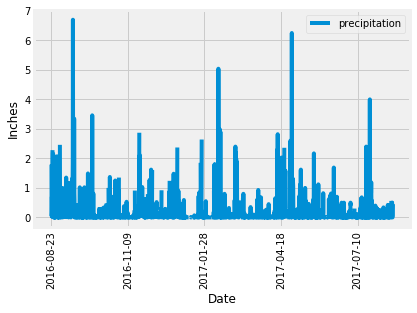

In [14]:
# Plot results using plot method
df.plot(rot = 90)
plt.xlabel("Date")
plt.ylabel("Inches")

In [15]:
# Use Pandas to print the summary statistics for the precipitation data, .T prints in table form
df.describe().T

,count,mean,std,min,25%,50%,75%,max
precipitation,2021.0,0.177279,0.46119,0.0,0.0,0.02,0.13,6.7


## Station Analysis

In [16]:
# Design a query to calculate the total number of stations
locations = session.query(Station).\
                      group_by(Station.station).\
                      count()
print(f'There are {locations} different stations.')

# Easy option
#session.query(func.count(Station.station)).all()


There are 9 different stations.


In [17]:
# Design a query to find the most active stations
# List the stations and the observation counts in descending order
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Which station has the highest number of observations 
most_active_station = active_stations[0].station
print(f"The most active station is {most_active_station}.")

The most active station is USC00519281.


In [19]:
# Using USC00519281 to calculate the lowest, highest, and average temperature
most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

print(f"The lowest, highest and average temps are {most_active_stats} for station {most_active_station}")

# Easy option
#session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    #filter(Measurement.station == "USC00519281").all()

The lowest, highest and average temps are [(54.0, 85.0, 71.66378066378067)] for station USC00519281


In [20]:
# Design a query to retrieve the last 12 months of temperature observations (TOBS) using USC00519281
previous_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= previous_year).all()


In [21]:
# Load results into a DataFrame
df = pd.DataFrame(results, columns = ["tobs"])
df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


Text(0.5, 18.5, 'Temperature')

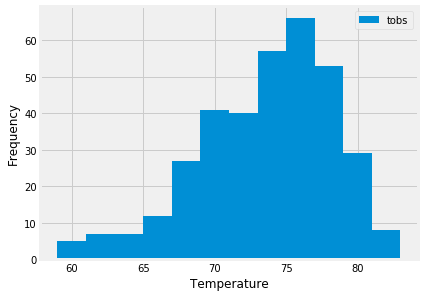

In [22]:
# Plot the results as a histogram
df.plot.hist(bins = 12)
plt.tight_layout()
plt.xlabel("Temperature")

## Bonus:  Other Recommended Analyses

### Temperature Analysis II (part I is on stats_bonus_pandas notebook)
* Plot the min, avg and max temperature as a bar chart.
* Use the average temperature as the bar height
* Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2015-06-23', '2015-06-30'))

[(69.0, 75.68518518518519, 81.0)]


In [24]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.

prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.36585365853658 74.0


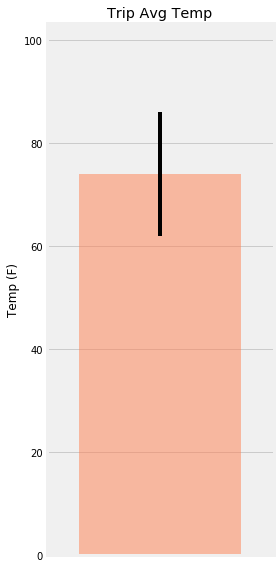

In [25]:
# Plot the min, avg and max temperature from previous query as a bar chart 
# Use the average temperature for the y value (bar height)
# Use the peak-to-peak (TMAX -TMIN) value as the y error bar (YERR)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

### Daily Rainfall Average

In [26]:
# Calculate the rainfall per weather station using the previous year's matching dates

start_date = '2012-01-01'
end_date = '2012-01-07'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0)]


In [27]:
# Calculate the daily normals.  Normals are the averages for the min, avg and max temperatures

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2018-01-01'
trip_end = '2018-01-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [29]:
# Load the list of daily normals into a DataFrame and set index to the date
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


Text(14.435000000000002, 0.5, 'Temperature')

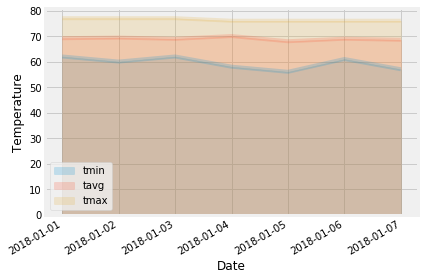

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")